In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import lightgbm as lgb
import xgboost as xgb

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.cluster import DBSCAN

In [5]:
from tpot.builtins import StackingEstimator

In [6]:
from sklearn.cluster import KMeans

In [7]:
filename = "uklon_sample_3_months_dropnan_driver_id.csv"

In [8]:
parse_dates = ['created_at']

In [9]:
df = pd.read_csv(filename, delimiter=",", parse_dates=parse_dates)

/home/temenid/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df.head()

,order_id,ride_id,created_at,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,user_id,driver_id,ride_distance,...,ooExtraCost,ooInitialCost,ooIdleCost,oapAzureMlCost,oapAzureMlCostBid,oapCostProvider,ooSurgeMultiplier,driver_lat,driver_lon,dtTaxiDriver_tdID
0,88314768,764A34A6-5C92-4A0C-90E8-82BDA5A5F9C1,2017-10-31 23:59:59.143,50.448906,30.386448,50.410267,30.412216,420361.0,568114.0,9.10,...,1.0,115.0,0.0,114.0,1.0,AzureML,1.35,50.437012,30.383680,568114.0
1,88314766,299E8328-8BE6-4097-AF81-4834478B4D51,2017-10-31 23:59:58.577,50.446000,30.576200,50.414604,30.384350,722883.0,553135.0,19.74,...,0.0,146.0,0.0,146.0,0.0,AzureML,1.00,50.449512,30.595537,553135.0
2,88314763,4EDC7FB9-5E34-4132-A2B3-B926F81DB439,2017-10-31 23:59:55.050,50.438610,30.459536,50.439339,30.444427,693323.0,568920.0,11.08,...,-7.0,100.0,0.0,107.0,1.0,AzureML,1.09,50.424972,30.458965,568920.0
3,88314762,D0EE9C9A-CFDD-44F8-906D-7C3A7ED65A1C,2017-10-31 23:59:54.420,50.449707,30.515345,50.459896,30.402002,17563.0,527239.0,9.24,...,0.0,88.0,0.0,88.0,0.0,NaN,1.00,50.455327,30.515555,527239.0
4,88314759,18B41EC0-B379-4621-BF7A-DD881D16E038,2017-10-31 23:59:50.053,50.397000,30.632500,50.416607,30.633417,754011.0,531709.0,3.73,...,0.0,55.0,0.0,NaN,NaN,NaN,1.01,NaN,NaN,NaN


In [11]:
df.columns

Index(['order_id', 'ride_id', 'created_at', 'pickup_lat', 'pickup_lon',
       'dropoff_lat', 'dropoff_lon', 'user_id', 'driver_id', 'ride_distance',
       'ooCancelReason', 'ooSuburbanDistance', 'ooCarSearchTime', 'ooCost',
       'ooExtraCost', 'ooInitialCost', 'ooIdleCost', 'oapAzureMlCost',
       'oapAzureMlCostBid', 'oapCostProvider', 'ooSurgeMultiplier',
       'driver_lat', 'driver_lon', 'dtTaxiDriver_tdID'],
      dtype='object')

In [12]:
df.isnull().sum()

order_id                    0
ride_id                     0
created_at                  0
pickup_lat                565
pickup_lon                565
dropoff_lat               780
dropoff_lon               780
user_id                378190
driver_id                   0
ride_distance               0
ooCancelReason              0
ooSuburbanDistance          0
ooCarSearchTime             0
ooCost                      0
ooExtraCost                 0
ooInitialCost               0
ooIdleCost                  0
oapAzureMlCost        1521212
oapAzureMlCostBid     1521212
oapCostProvider       1350984
ooSurgeMultiplier           0
driver_lat             417486
driver_lon             417486
dtTaxiDriver_tdID      417486
dtype: int64

In [13]:
df.shape

(2815393, 24)

In [14]:
df = df.sample(n=900000)

In [15]:
df.shape

(900000, 24)

In [16]:
# Remove rows with missing values in column 'driver_id'. The order was not accepted. there was no trip
new_df = df.dropna(subset=['driver_id','pickup_lat','pickup_lon','dropoff_lat','dropoff_lon'],inplace=False)

In [17]:
# leave only uncanceled ride
new_df = new_df.loc[df['ooCancelReason'] == 0]

In [18]:
new_df.shape

(757460, 24)

In [19]:
# initialy select the following columns
data = new_df[['created_at','ride_distance', 'ooSuburbanDistance', 'ooCarSearchTime', 'ooCost','ooIdleCost','pickup_lat','pickup_lon','dropoff_lat','dropoff_lon','ooSurgeMultiplier']] # ,'ooIdleCost'

In [20]:
data[data['ooIdleCost'] >0].head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,ooSurgeMultiplier
1357912,2017-09-19 23:48:06.987,15.73,0,10,160.0,30.0,50.416172,30.373804,50.445843,30.381115,1.0
2044674,2017-08-28 03:40:09.677,16.69,0,7,230.0,36.0,50.440918,30.281620,50.410507,30.438560,1.0
1458122,2017-09-16 16:22:31.537,5.48,0,11,74.0,10.0,50.502050,30.497208,50.490410,30.475090,1.0
1013032,2017-10-01 00:25:30.557,22.66,0,1,184.0,22.0,50.425888,30.596878,50.453750,30.346897,1.0
1492017,2017-09-15 18:24:02.213,12.59,0,30,125.0,10.0,50.405216,30.336311,50.362907,30.461594,1.0


In [21]:
# count the NaN values in a columns
data.isnull().sum()

created_at            0
ride_distance         0
ooSuburbanDistance    0
ooCarSearchTime       0
ooCost                0
ooIdleCost            0
pickup_lat            0
pickup_lon            0
dropoff_lat           0
dropoff_lon           0
ooSurgeMultiplier     0
dtype: int64

In [22]:
data['corrCost'] = data.apply(lambda row: row['ooCost'] - row['ooIdleCost'], axis=1)

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
# some simple feature engineering with date
# as categorical
data['quarter'] = data['created_at'].dt.quarter.astype(str)
data['month'] = data['created_at'].dt.month.astype(str)
data['day'] = data['created_at'].dt.day.astype(str)
data['dayofweek'] = data['created_at'].dt.dayofweek.astype(str)
data['hour'] = data['created_at'].dt.hour.astype(str)
data['date'] = data['created_at'].dt.strftime('%Y-%m-%d')
data['floor_date'] = data['created_at'].dt.floor('30min').astype(str)

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [24]:
# as categorical
data['quarter_int'] = data['created_at'].dt.quarter.astype(int)
data['month_int'] = data['created_at'].dt.month.astype(int)
data['day_int'] = data['created_at'].dt.day.astype(int)
data['dayofweek_int'] = data['created_at'].dt.dayofweek.astype(int)
data['hour_int'] = data['created_at'].dt.hour.astype(int)

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [25]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,day,dayofweek,hour,date,floor_date,quarter_int,month_int,day_int,dayofweek_int,hour_int
596960,2017-10-13 18:04:48.503,3.42,0,12,80.0,0.0,50.439064,30.507288,50.451275,30.472069,...,13,4,18,2017-10-13,2017-10-13 18:00:00,4,10,13,4,18
2574808,2017-08-09 11:56:03.470,12.31,0,1,114.0,0.0,50.483845,30.406494,50.426777,30.503254,...,9,2,11,2017-08-09,2017-08-09 11:30:00,3,8,9,2,11
334917,2017-10-21 19:25:36.560,10.30,0,6,91.0,0.0,50.469471,30.604008,50.427460,30.667645,...,21,5,19,2017-10-21,2017-10-21 19:00:00,4,10,21,5,19
827144,2017-10-06 23:02:37.683,3.69,0,10,55.0,0.0,50.447163,30.594608,50.425285,30.592943,...,6,4,23,2017-10-06,2017-10-06 23:00:00,4,10,6,4,23
1123188,2017-09-27 21:33:51.863,3.40,0,11,56.0,0.0,50.415092,30.545816,50.435661,30.540985,...,27,2,21,2017-09-27,2017-09-27 21:30:00,3,9,27,2,21


In [26]:
dt = {'date': ['2017-08-24', '2017-10-14'], 
        'isHolidays': [1, 1]}
holidays = pd.DataFrame(dt, columns = ['date', 'isHolidays'])

In [27]:
weather = pd.read_csv('weather_history_2017.csv', delimiter=";", decimal=',')

In [28]:
weather.head()

,floor_date,"Temp,C",Weather,"Wind,km/h",Humidity,"Barometer,mbar"
0,2017-08-01 00:00:00,19,Clear,6,0.83,1020
1,2017-08-01 00:30:00,18,Clear,6,0.94,1021
2,2017-08-01 01:00:00,18,Clear,6,0.88,1021
3,2017-08-01 01:30:00,18,Clear,6,0.88,1021
4,2017-08-01 02:00:00,18,Clear,6,0.88,1021


In [29]:
weather.describe()

,"Temp,C","Wind,km/h",Humidity,"Barometer,mbar"
count,4416.000000,4416.000000,4416.000000,4416.000000
mean,15.276042,12.468976,0.721587,1015.846241
std,7.707456,7.541801,0.187891,8.560472
min,-3.000000,0.000000,0.200000,978.000000
25%,9.000000,6.000000,0.590000,1011.000000
50%,14.000000,13.000000,0.750000,1016.000000
75%,21.000000,17.000000,0.880000,1020.000000
max,34.000000,43.000000,1.000000,1039.000000


In [30]:
data = pd.merge(data, holidays, on='date', how='left')

In [31]:
data = pd.merge(data, weather, on='floor_date', how='left')

In [32]:
data['isHolidays'].fillna(value=0, inplace=True)

In [33]:
data.isnull().sum()

created_at            0
ride_distance         0
ooSuburbanDistance    0
ooCarSearchTime       0
ooCost                0
ooIdleCost            0
pickup_lat            0
pickup_lon            0
dropoff_lat           0
dropoff_lon           0
ooSurgeMultiplier     0
corrCost              0
quarter               0
month                 0
day                   0
dayofweek             0
hour                  0
date                  0
floor_date            0
quarter_int           0
month_int             0
day_int               0
dayofweek_int         0
hour_int              0
isHolidays            0
Temp,C                0
Weather               0
Wind,km/h             0
Humidity              0
Barometer,mbar        0
dtype: int64

In [34]:
test = data[data['Temp,C'].isnull()]

In [35]:
test[['floor_date', 'Temp,C']]

,floor_date,"Temp,C"


In [36]:
data.shape

(757460, 30)

In [37]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,month_int,day_int,dayofweek_int,hour_int,isHolidays,"Temp,C",Weather,"Wind,km/h",Humidity,"Barometer,mbar"
0,2017-10-13 18:04:48.503,3.42,0,12,80.0,0.0,50.439064,30.507288,50.451275,30.472069,...,10,13,4,18,0.0,11,Clear,20,0.67,1012
1,2017-08-09 11:56:03.470,12.31,0,1,114.0,0.0,50.483845,30.406494,50.426777,30.503254,...,8,9,2,11,0.0,23,Clear,20,0.61,1024
2,2017-10-21 19:25:36.560,10.30,0,6,91.0,0.0,50.469471,30.604008,50.427460,30.667645,...,10,21,5,19,0.0,10,Fog,9,0.88,1014
3,2017-10-06 23:02:37.683,3.69,0,10,55.0,0.0,50.447163,30.594608,50.425285,30.592943,...,10,6,4,23,0.0,6,Clear,6,0.93,1008
4,2017-09-27 21:33:51.863,3.40,0,11,56.0,0.0,50.415092,30.545816,50.435661,30.540985,...,9,27,2,21,0.0,9,Clear,17,0.62,1036


### Clusterization

In [38]:
pickup_coords = data.loc[:,['pickup_lat','pickup_lon']]
dropoff_coords = data.loc[:,['dropoff_lat','dropoff_lon']]
ride_coords = data.loc[:,['pickup_lat','pickup_lon','dropoff_lat','dropoff_lon']]

In [39]:
num_pickup_clusters = 7
num_dropoff_clusters = 7
num_ride_clusters = 7

In [40]:
pickup_kmeans = KMeans(n_clusters=num_pickup_clusters, random_state=1).fit(pickup_coords)

In [41]:
dropoff_kmeans = KMeans(n_clusters=num_dropoff_clusters, random_state=1).fit(dropoff_coords)

In [42]:
ride_kmeans = KMeans(n_clusters=num_ride_clusters, random_state=1).fit(ride_coords)

In [43]:
id_pickup_label=pickup_kmeans.labels_
id_dropoff_label=dropoff_kmeans.labels_
id_ride_label=ride_kmeans.labels_

In [44]:
id_pickup_label.shape, id_dropoff_label.shape

((757460,), (757460,))

In [45]:
data['pickup_cluster'] = id_pickup_label.astype(str)
data['dropoff_cluster'] = id_dropoff_label.astype(str)
data['ride_cluster'] = id_ride_label.astype(str)

In [46]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,hour_int,isHolidays,"Temp,C",Weather,"Wind,km/h",Humidity,"Barometer,mbar",pickup_cluster,dropoff_cluster,ride_cluster
0,2017-10-13 18:04:48.503,3.42,0,12,80.0,0.0,50.439064,30.507288,50.451275,30.472069,...,18,0.0,11,Clear,20,0.67,1012,0,6,3
1,2017-08-09 11:56:03.470,12.31,0,1,114.0,0.0,50.483845,30.406494,50.426777,30.503254,...,11,0.0,23,Clear,20,0.61,1024,2,0,0
2,2017-10-21 19:25:36.560,10.30,0,6,91.0,0.0,50.469471,30.604008,50.427460,30.667645,...,19,0.0,10,Fog,9,0.88,1014,6,3,4
3,2017-10-06 23:02:37.683,3.69,0,10,55.0,0.0,50.447163,30.594608,50.425285,30.592943,...,23,0.0,6,Clear,6,0.93,1008,6,3,4
4,2017-09-27 21:33:51.863,3.40,0,11,56.0,0.0,50.415092,30.545816,50.435661,30.540985,...,21,0.0,9,Clear,17,0.62,1036,0,0,3


In [47]:
data.tail()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,hour_int,isHolidays,"Temp,C",Weather,"Wind,km/h",Humidity,"Barometer,mbar",pickup_cluster,dropoff_cluster,ride_cluster
757455,2017-10-25 18:59:48.960,12.79,0,15,155.0,0.0,50.440441,30.524998,50.407505,30.634874,...,18,0.0,2,Clear,9,0.75,1027,0,3,6
757456,2017-09-18 13:08:59.570,11.69,0,1,115.0,0.0,50.482090,30.453037,50.413403,30.514238,...,13,0.0,22,Clear,32,0.36,1012,5,0,0
757457,2017-10-31 23:17:42.527,4.34,0,15,76.0,0.0,50.441800,30.512100,50.434216,30.472420,...,23,0.0,3,Clear,28,0.65,1009,0,6,3
757458,2017-09-17 06:18:03.930,13.77,0,2,130.0,0.0,50.439700,30.516790,50.422310,30.468449,...,6,0.0,18,Clouds,6,0.43,1017,0,6,3
757459,2017-08-30 13:05:42.593,4.50,0,22,77.0,0.0,50.424900,30.325205,50.428936,30.357359,...,13,0.0,13,Clouds,13,0.67,1022,2,2,5


In [48]:
data.shape

(757460, 33)

In [49]:
data.describe()

,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,ooSurgeMultiplier,...,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays,"Temp,C","Wind,km/h",Humidity,"Barometer,mbar"
count,757460.000000,757460.0,757460.000000,757460.000000,757460.000000,757460.000000,757460.000000,757460.000000,757460.000000,757460.00000,...,757460.000000,757460.000000,757460.000000,757460.000000,757460.000000,757460.000000,757460.000000,757460.000000,757460.000000,757460.000000
mean,11.043576,0.0,19.092303,105.313145,0.426801,50.446194,30.513717,50.446145,30.513804,1.04301,...,3.360674,9.047415,15.849927,3.009002,13.338440,0.021694,15.451476,13.043322,0.705855,1015.665901
std,7.237943,0.0,30.965949,50.166542,3.422001,0.038573,0.082841,0.040678,0.088824,0.13584,...,0.480196,0.819564,8.874459,1.953912,6.569012,0.145681,7.815674,7.769417,0.188402,8.614526
min,0.010000,0.0,0.000000,30.000000,0.000000,50.084835,29.959909,50.064350,29.884018,1.00000,...,3.000000,8.000000,1.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,0.200000,978.000000
25%,5.610000,0.0,5.000000,70.000000,0.000000,50.422882,30.466902,50.421711,30.464384,1.00000,...,3.000000,8.000000,8.000000,1.000000,9.000000,0.000000,9.000000,9.000000,0.570000,1011.000000
50%,9.950000,0.0,9.000000,100.000000,0.000000,50.442516,30.510630,50.442337,30.508944,1.00000,...,3.000000,9.000000,16.000000,3.000000,14.000000,0.000000,14.000000,13.000000,0.720000,1016.000000
75%,14.500000,0.0,23.000000,125.000000,0.000000,50.465675,30.546171,50.467197,30.553558,1.00000,...,4.000000,10.000000,23.000000,5.000000,19.000000,0.000000,21.000000,17.000000,0.870000,1020.000000
max,142.840000,0.0,4430.000000,4062.000000,300.000000,50.812706,30.988825,50.812706,30.996086,3.50000,...,4.000000,10.000000,31.000000,6.000000,23.000000,1.000000,34.000000,43.000000,1.000000,1039.000000


In [50]:
# In our dataset, we have both categorical and numeric data. select them for different processing

In [51]:
# CATEGORICAL (for the moment only these)
catFeatures = ['quarter','month','day','dayofweek', 'pickup_cluster', 'dropoff_cluster','ride_cluster','Weather']

In [52]:
# Convert categorical variable into dummy/indicator variables
df_cat = pd.get_dummies(data[catFeatures])

In [53]:
# let's check
df_cat.head()

,quarter_3,quarter_4,month_10,month_8,month_9,day_1,day_10,day_11,day_12,day_13,...,ride_cluster_5,ride_cluster_6,Weather_Clear,Weather_Clouds,Weather_Drizzle,Weather_Fog,Weather_Rain,Weather_Snow,Weather_Sprinkles,Weather_Thunder
0,0,1,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [54]:
# concat dummy/indicator variables to dataframe
data = pd.concat([data, df_cat], axis=1)

In [55]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,ride_cluster_5,ride_cluster_6,Weather_Clear,Weather_Clouds,Weather_Drizzle,Weather_Fog,Weather_Rain,Weather_Snow,Weather_Sprinkles,Weather_Thunder
0,2017-10-13 18:04:48.503,3.42,0,12,80.0,0.0,50.439064,30.507288,50.451275,30.472069,...,0,0,1,0,0,0,0,0,0,0
1,2017-08-09 11:56:03.470,12.31,0,1,114.0,0.0,50.483845,30.406494,50.426777,30.503254,...,0,0,1,0,0,0,0,0,0,0
2,2017-10-21 19:25:36.560,10.30,0,6,91.0,0.0,50.469471,30.604008,50.427460,30.667645,...,0,0,0,0,0,1,0,0,0,0
3,2017-10-06 23:02:37.683,3.69,0,10,55.0,0.0,50.447163,30.594608,50.425285,30.592943,...,0,0,1,0,0,0,0,0,0,0
4,2017-09-27 21:33:51.863,3.40,0,11,56.0,0.0,50.415092,30.545816,50.435661,30.540985,...,0,0,1,0,0,0,0,0,0,0


In [56]:
# drop useless categorical column (because we have dummy/indicator variables)
data.drop(catFeatures, axis=1,inplace=True)

In [57]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,ooIdleCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,...,ride_cluster_5,ride_cluster_6,Weather_Clear,Weather_Clouds,Weather_Drizzle,Weather_Fog,Weather_Rain,Weather_Snow,Weather_Sprinkles,Weather_Thunder
0,2017-10-13 18:04:48.503,3.42,0,12,80.0,0.0,50.439064,30.507288,50.451275,30.472069,...,0,0,1,0,0,0,0,0,0,0
1,2017-08-09 11:56:03.470,12.31,0,1,114.0,0.0,50.483845,30.406494,50.426777,30.503254,...,0,0,1,0,0,0,0,0,0,0
2,2017-10-21 19:25:36.560,10.30,0,6,91.0,0.0,50.469471,30.604008,50.427460,30.667645,...,0,0,0,0,0,1,0,0,0,0
3,2017-10-06 23:02:37.683,3.69,0,10,55.0,0.0,50.447163,30.594608,50.425285,30.592943,...,0,0,1,0,0,0,0,0,0,0
4,2017-09-27 21:33:51.863,3.40,0,11,56.0,0.0,50.415092,30.545816,50.435661,30.540985,...,0,0,1,0,0,0,0,0,0,0


In [58]:
#INTEGER
intFeatures = ['ride_distance','ooSuburbanDistance','ooCarSearchTime','quarter_int','month_int','day_int','dayofweek_int','ooSurgeMultiplier','Temp,C','Wind,km/h','Humidity','Barometer,mbar']

In [59]:
# integer features scaling
scaler = MinMaxScaler()
data[intFeatures] = scaler.fit_transform(data[intFeatures])

In [60]:
# split features and target
dfX = data.drop(['pickup_lat','pickup_lon','dropoff_lat','dropoff_lon','created_at','date','ooCost','ooIdleCost','corrCost','floor_date'], axis=1)
dfY = data['corrCost']

In [61]:
dfX.head()

,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooSurgeMultiplier,hour,quarter_int,month_int,day_int,dayofweek_int,hour_int,...,ride_cluster_5,ride_cluster_6,Weather_Clear,Weather_Clouds,Weather_Drizzle,Weather_Fog,Weather_Rain,Weather_Snow,Weather_Sprinkles,Weather_Thunder
0,0.023875,0.0,0.002709,0.0,18,1.0,1.0,0.400000,0.666667,18,...,0,0,1,0,0,0,0,0,0,0
1,0.086116,0.0,0.000226,0.0,11,0.0,0.0,0.266667,0.333333,11,...,0,0,1,0,0,0,0,0,0,0
2,0.072044,0.0,0.001354,0.0,19,1.0,1.0,0.666667,0.833333,19,...,0,0,0,0,0,1,0,0,0,0
3,0.025765,0.0,0.002257,0.0,23,1.0,1.0,0.166667,0.666667,23,...,0,0,1,0,0,0,0,0,0,0
4,0.023735,0.0,0.002483,0.0,21,0.0,0.5,0.866667,0.333333,21,...,0,0,1,0,0,0,0,0,0,0


In [62]:
dfY.head()

0     80.0
1    114.0
2     91.0
3     55.0
4     56.0
Name: corrCost, dtype: float64

In [63]:
# get features names
fNames = dfX.columns

In [64]:
fNames

Index(['ride_distance', 'ooSuburbanDistance', 'ooCarSearchTime',
       'ooSurgeMultiplier', 'hour', 'quarter_int', 'month_int', 'day_int',
       'dayofweek_int', 'hour_int', 'isHolidays', 'Temp,C', 'Wind,km/h',
       'Humidity', 'Barometer,mbar', 'quarter_3', 'quarter_4', 'month_10',
       'month_8', 'month_9', 'day_1', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_2',
       'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26',
       'day_27', 'day_28', 'day_29', 'day_3', 'day_30', 'day_31', 'day_4',
       'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'dayofweek_0',
       'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4',
       'dayofweek_5', 'dayofweek_6', 'pickup_cluster_0', 'pickup_cluster_1',
       'pickup_cluster_2', 'pickup_cluster_3', 'pickup_cluster_4',
       'pickup_cluster_5', 'pickup_cluster_6', 'dropoff_cluster_0',
       'dropoff_cluster_1', 'dropoff_cluster_2', 'dropoff_cl

In [65]:
# Get values
# features
X = dfX[fNames].values
# targets
y = dfY.values

In [66]:
X.shape, y.shape

((757460, 87), (757460,))

In [67]:
# Split our data into random train and test subsets with specific proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [68]:
X_train.shape, y_train.shape

((568095, 87), (568095,))

### simple linear regression

In [69]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [70]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [72]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 295.05


In [73]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [74]:
mean_absolute_percentage_error(y_test, y_pred)

9.236280637163553

### RandomForestRegressor

In [75]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [76]:
# Make predictions using the testing set
y_pred = rf.predict(X_test)

In [77]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 287.67


In [78]:
mean_absolute_percentage_error(y_test, y_pred)

9.218174240267377

### xgboost

In [79]:
xgb_model = xgb.XGBRegressor(random_state=1)

In [80]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [81]:
y_pred = xgb_model.predict(X_test)

In [82]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 279.87


In [83]:
mean_absolute_percentage_error(y_test, y_pred)

8.967229031339647

### LightGBM

In [84]:
lgb_model = lgb.LGBMRegressor(objective='mape',n_estimators=400, learning_rate=0.2, num_leaves=75, random_state=1)

In [85]:
lgb_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.2, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=400,
       n_jobs=-1, num_leaves=75, objective='mape', random_state=1,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [86]:
y_pred = lgb_model.predict(X_test)

In [87]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 312.72


In [88]:
mean_absolute_percentage_error(y_test, y_pred)

6.965795262965485

In [89]:
feature_importances = lgb_model.feature_importances_

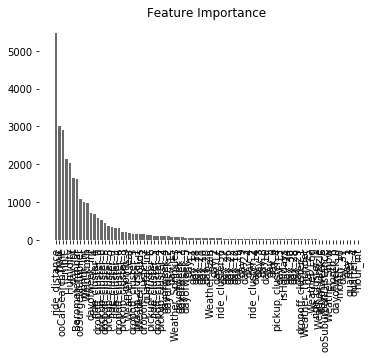

In [90]:
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]


# Create plot
plt.figure()
plt.title("Feature Importance")

# Add bars
plt.bar(range(len(fNames)), feature_importances[indices], color = 'dimgray')

# Add feature names as x-axis labels
plt.xticks(range(len(fNames)), fNames[indices], rotation=90)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.show()

In [91]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(fNames, feature_importances):
    feats[feature] = importance #add the name/value pair 

# create DataFrame
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature importances'})

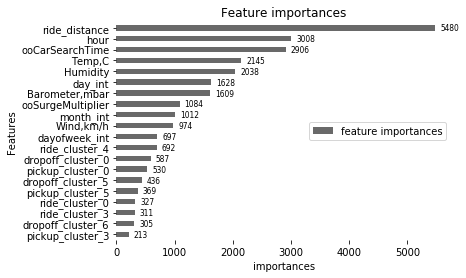

In [92]:
ax = importances.sort_values(by='feature importances').tail(20).plot(kind='barh', color = 'dimgray')

for p in ax.patches:
    ax.annotate(
        str(int(p.get_width())),
        (p.get_x() + p.get_width(), p.get_y()),
        xytext=(5,0),
        textcoords='offset points',
        horizontalalignment='left',
        fontsize=7.5
)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.title('Feature importances')
plt.xlabel('importances')
plt.ylabel('Features')
plt.legend(loc="center right")
plt.show()

### ExtraTreesRegressor

In [93]:
etr = ExtraTreesRegressor(random_state=1)

In [94]:
etr.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=1, verbose=0, warm_start=False)

In [95]:
y_pred = etr.predict(X_test)

In [96]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 327.29


In [97]:
mean_absolute_percentage_error(y_test, y_pred)

9.588034926737883